In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt

# Load data
def read_mortality_csv(zip_file):
  import io
  import csv
  fields, cities, values = None, [], []
  with io.TextIOWrapper(zip_file.open('data_and_materials/mortality.csv')) as wrap:
    csv_reader = csv.reader(wrap, delimiter=',', quotechar='"')
    fields = next(csv_reader)[1:]
    for row in csv_reader:
      cities.append(row[0])
      values.append(tuple(map(float, row[1:])))
  dtype = np.dtype([(name, float) for name in fields])
  return cities, fields, np.array(values, dtype=dtype).view(np.recarray)

with zipfile.ZipFile("hw0_data_and_materials.zip") as zip_file:
  syn_X, syn_y = ( np.loadtxt(zip_file.open('data_and_materials/{}'.format(fname)), delimiter=',') for fname in ['syn_X.csv', 'syn_y.csv'] )
  m_cities, m_fields, m_values = read_mortality_csv(zip_file)

Part (a)

In [2]:
def add_intercept(X):
  return np.concatenate((np.ones_like(X[:,:1]), X), axis=1)

def matrix_inverse_OLS(X, y):
  return linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

import numpy.linalg as linalg
beta_hat = matrix_inverse_OLS(add_intercept(syn_X), syn_y)
print(beta_hat)

[ 1.92960603  1.26397096 -4.59799331]


Part (b)

In [3]:
def loss_fn(beta, X, y):
  # (y - X beta)^T (y - X beta)
  return np.sum(np.square(y - X.dot(beta)))

def loss_grad(beta, X, y):
  # -2*(y - X beta)^T X
  return -2*(y - X.dot(beta)).T.dot(X)

def gradient_step(beta, step_size, X, y):
  loss, grads = loss_fn(beta, X, y), loss_grad(beta, X, y)
  # beta_(i+1) = beta_i - alpha (del f)^T
  beta = beta - step_size * grads.T
  return loss, beta

def gradient_descent(X, y, step_size, precision, max_iter=10000, warn_max_iter=True):
  beta = np.zeros_like(X[0])
  losses = [] # Array for recording the value of the loss over the iterations.
  graceful = False
  for _ in range(max_iter):
    beta_last = beta # Save last values of beta for later stopping criterion
    loss, beta = gradient_step(beta, step_size, X, y)
    losses.append(loss)
    # Use the norm of the difference between the new beta and the old beta as a stopping criteria
    if np.sqrt(np.sum(np.square((beta - beta_last)/beta))) < precision:
      graceful = True
      break
  if not graceful and warn_max_iter:
    print("Reached max iterations.")
  return beta, np.array(losses)


BetaHat = [ 1.92960603  1.26397096 -4.5979933 ]


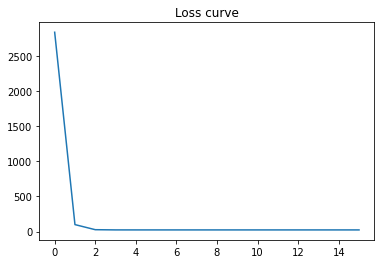

Optimal step size is 0.0042000000000000015 with 9.0 steps


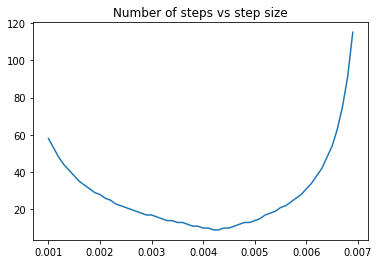

In [4]:
# In my experimentation, it seems a step size of 0.004 converges the fastest
beta_gd, losses = gradient_descent(add_intercept(syn_X), syn_y, 0.004, 1e-8)
print("BetaHat = {}".format(beta_gd))
plt.plot(range(len(losses)), losses)
plt.title("Loss curve")
plt.show()
# Now run a scan over the step size in order to confirm this
step_size_scan_range = np.arange(0.001, 0.007, 0.0001)
step_scan = np.array([ (step_size, len(gradient_descent(syn_X, syn_y, step_size, 1e-6, warn_max_iter=False)[1])) for step_size in step_size_scan_range ]).T
print("Optimal step size is {} with {} steps".format(*step_scan[:, np.argmin(step_scan[1])]))
plt.plot(step_scan[0], step_scan[1])
plt.title("Number of steps vs step size")
plt.show()

Part (c-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in square
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


Reached max iterations.
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
nan


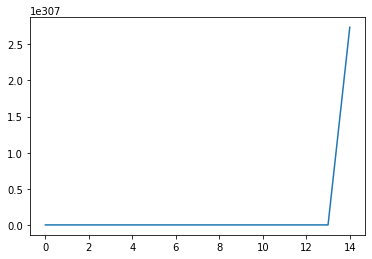

In [5]:
m_y = m_values.Mortality
m_X = np.array([ m_values[f] for f in m_fields if f != 'Mortality']).T # Arrange our X matrix in the same order as the data set, but without the Mortality column.
# Then run the gradient descent, notice the many overflow warnings and the result is all NaNs
m_beta_gd, m_losses = gradient_descent(add_intercept(m_X), m_y, 0.0001, 1e-6, max_iter=100000)
print(m_beta_gd)
print(m_losses[-1])
plt.plot(range(len(m_losses)), m_losses)
plt.show()

Part (c-2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


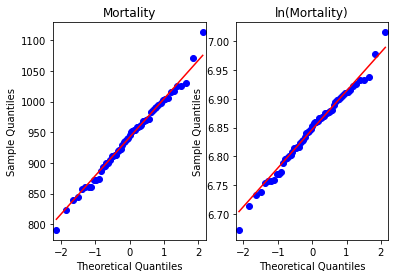

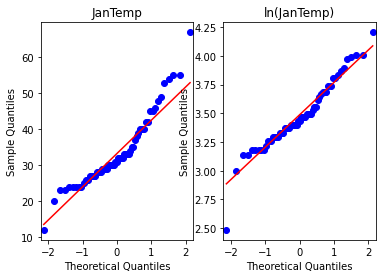

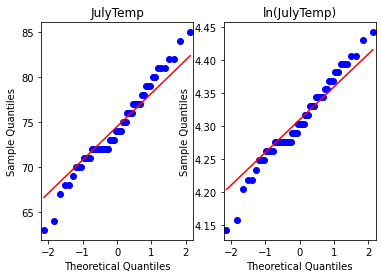

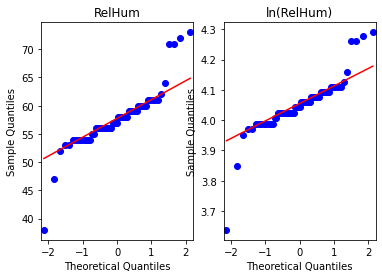

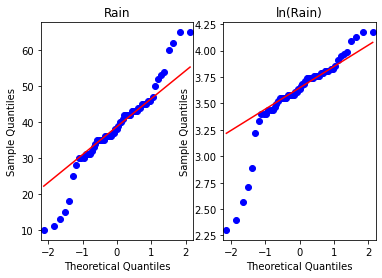

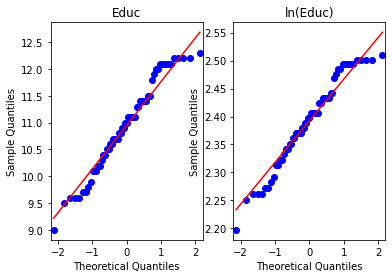

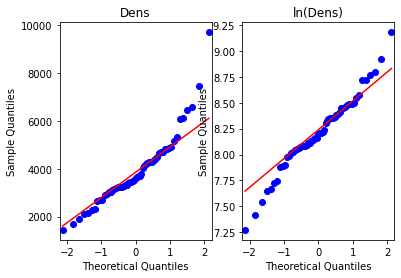

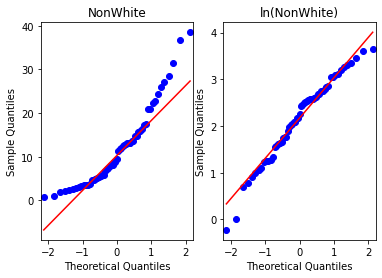

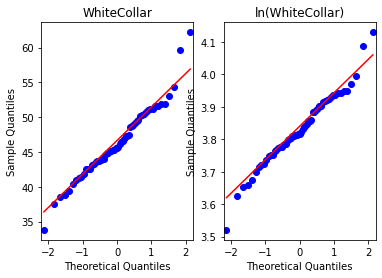

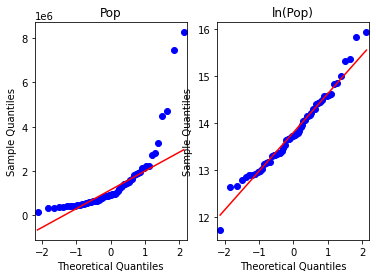

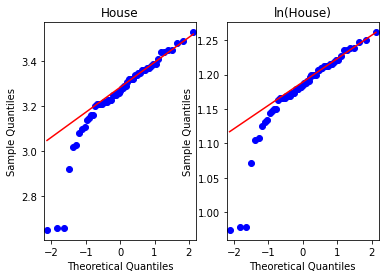

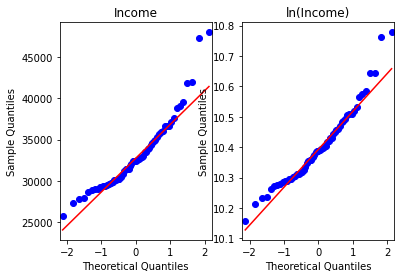

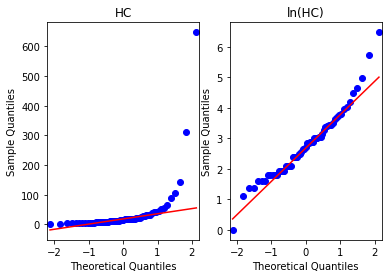

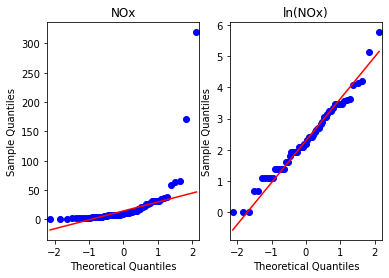

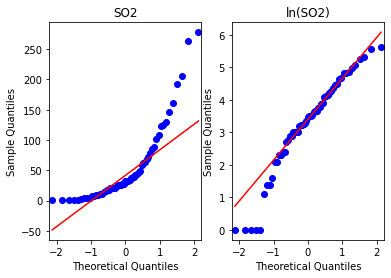

In [6]:
import statsmodels.api as sm
# Here we will make a matrix of Q-Q plots for easy comparison.
for f in m_fields:
  fig = sm.qqplot(m_values[f], line='q', ax=plt.subplot(1, 2, 1))
  plt.title(f)
  fig = sm.qqplot(np.log(m_values[f]), line='q', ax=plt.subplot(1, 2, 2))
  plt.title("ln({})".format(f))
  plt.show()
# The first thing we can notice from this is the very wide range of values that some variables take

BetaHat = [-3.23518989e-16 -2.34383043e-01 -2.17493774e-01  1.17210258e-02
  1.79782135e-01 -1.50536200e-01  1.08944152e-01  7.64353974e-01
 -1.21215024e-01  8.40238140e-02 -1.11470199e-01 -3.04637180e-02
 -9.95574546e-01  8.80420236e-01  8.62034954e-02]
Final loss value = 13.809259449677194


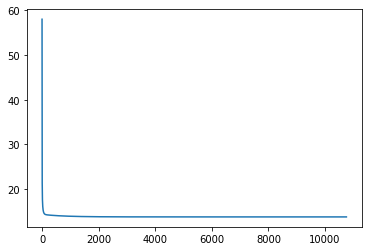

Matrix inverse BetaHat = [-3.35096046e-16 -2.34377091e-01 -2.17496828e-01  1.17238925e-02
  1.79754504e-01 -1.50544513e-01  1.08945825e-01  7.64348559e-01
 -1.21202349e-01  8.40325965e-02 -1.11479218e-01 -3.04687337e-02
 -9.96190618e-01  8.81043305e-01  8.61146149e-02]


In [8]:
# To combat this, we scale these values by their mean and standard deviation.
# Note we also do this for y
m_X_scaled = (m_X - m_X.mean(axis=0))/m_X.std(axis=0, ddof=1)
m_Y_scaled = (m_y - m_y.mean())/m_y.std(ddof=1)
m_X_inter = add_intercept(m_X_scaled)
# Running gradient descent now works.
m_beta_gd, m_losses = gradient_descent(m_X_inter, m_Y_scaled, 0.001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))
plt.plot(range(len(m_losses)), m_losses)
plt.show()
# As a sanity check, we can also do the matrix inversion 
print("Matrix inverse BetaHat = {}".format(matrix_inverse_OLS(m_X_inter, m_Y_scaled)))

Part (d)

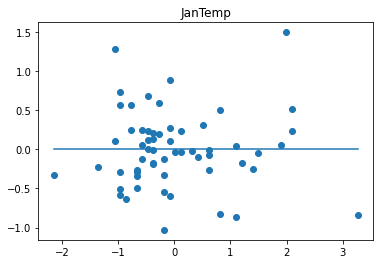

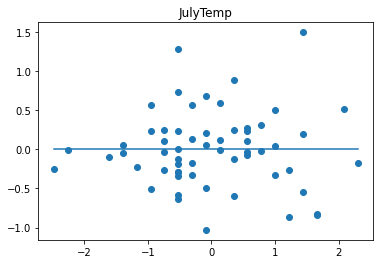

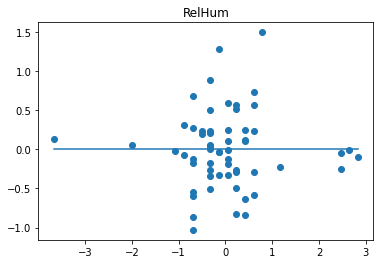

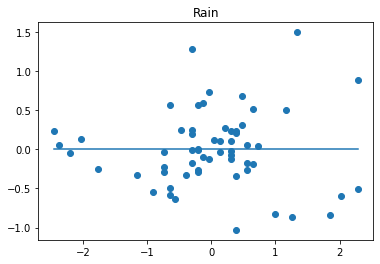

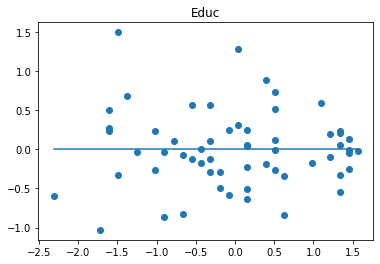

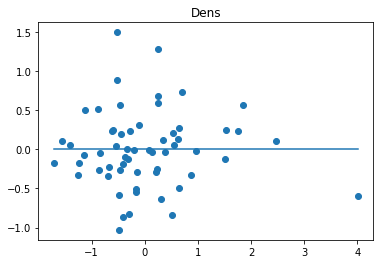

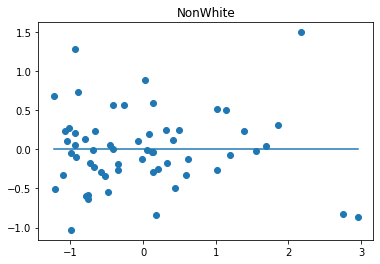

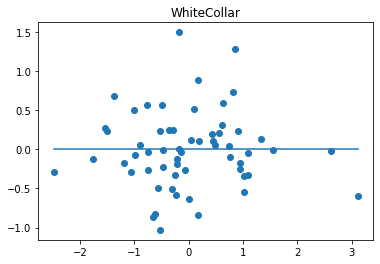

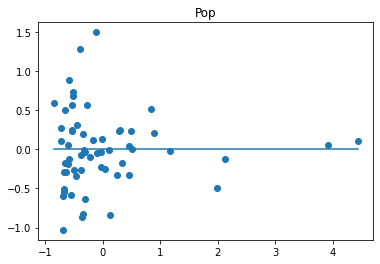

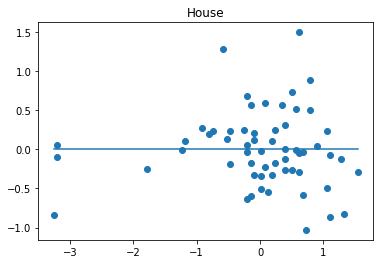

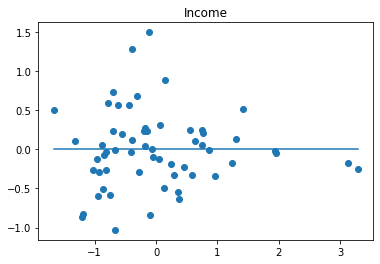

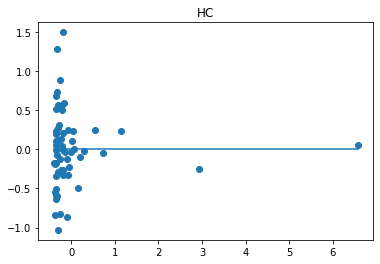

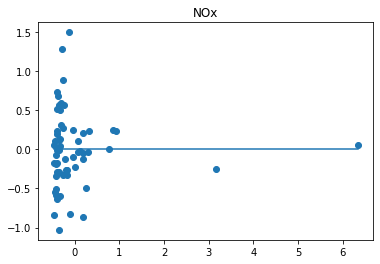

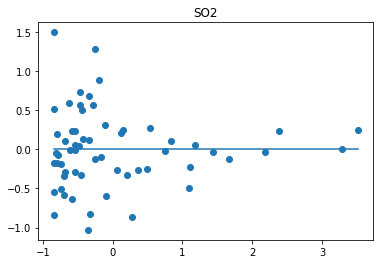

In [ ]:
# Here we plot the residuals, so assess the quality of the fit
for i, f in enumerate([ f for f in m_fields if f != 'Mortality']):
  plt.plot(sorted(m_X_scaled.T[i]), np.zeros_like(m_Y_scaled))
  plt.scatter(m_X_scaled.T[i], m_Y_scaled - m_X_inter.dot(m_beta_gd))
  plt.title(f)
  plt.show()

Reached max iterations.
BetaHat = [-3.61470294e-18  1.00000000e+00 -5.99998096e-15 -6.97447476e-16
  1.69924671e-16  7.57682608e-15 -2.96390543e-15  3.44178465e-16
  9.68407781e-15 -2.36446707e-15  1.34457286e-15 -8.19313753e-16
 -1.44192727e-15 -4.86629605e-15  1.22522903e-14 -1.88970763e-15]
Final loss value = 4.914728091627992e-27


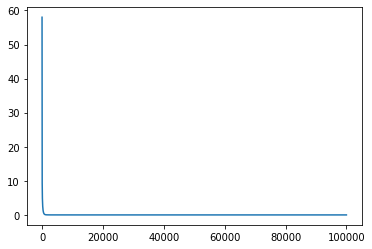

In [9]:
# From the residuals, and the Q-Q plots, we find the following variables deviate significantly from normality: ['NonWhite','Pop','HC','NOx','SO2']
# So we perofrm a log transform on the _non-scaled_ values
m_X_transformed = np.array([ m_values[f] if f not in ['NonWhite','Pop','HC','NOx','SO2'] else np.log(m_values[f]) for f in m_fields ]).T
# After the transform, we then rescale all variables accroding to the new means and standard deviations
m_X_transformed_scaled = (m_X_transformed - m_X_transformed.mean(axis=0))/m_X_transformed.std(axis=0, ddof=1)
m_X_ts_inter = add_intercept(m_X_transformed_scaled)
# Then perform the gradient descent again
m_beta_gd, m_losses = gradient_descent(m_X_ts_inter, m_Y_scaled, 0.0001, 1e-6, max_iter=100000)
print("BetaHat = {}".format(m_beta_gd))
print("Final loss value = {}".format(m_losses[-1]))
plt.plot(range(len(m_losses)), m_losses)
plt.show()

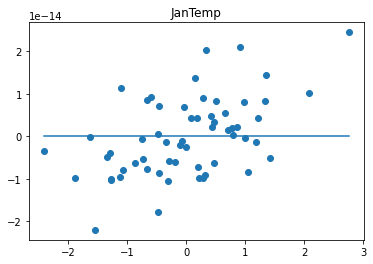

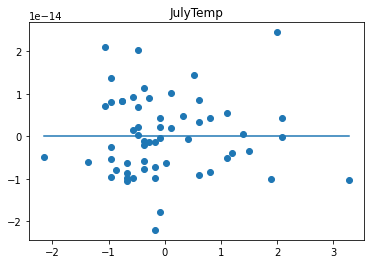

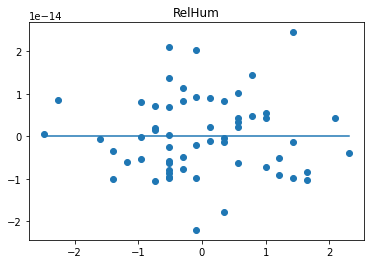

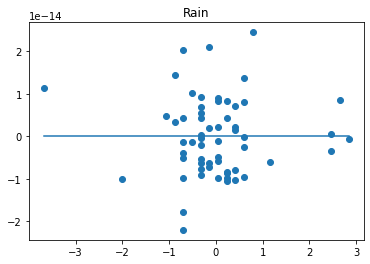

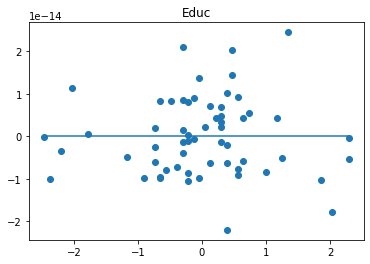

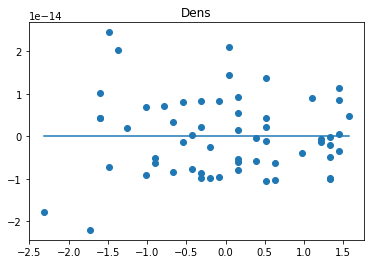

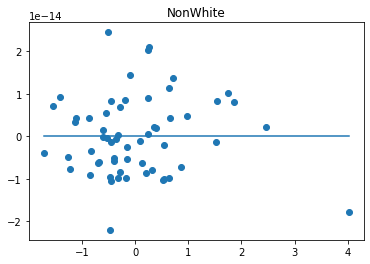

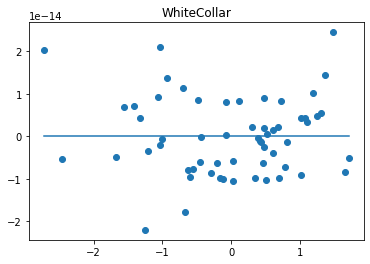

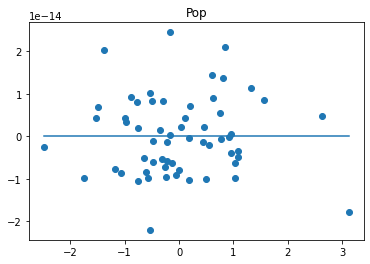

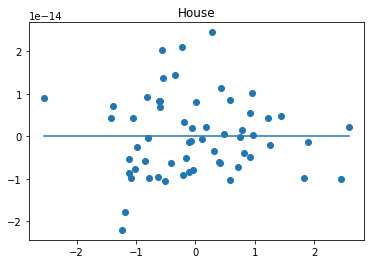

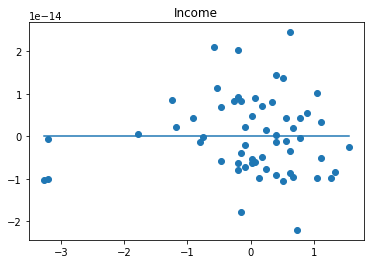

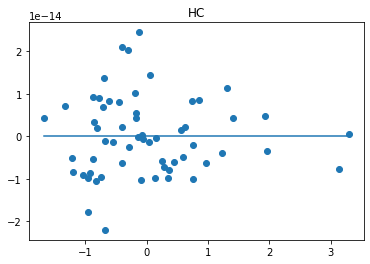

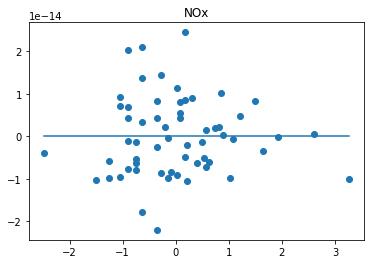

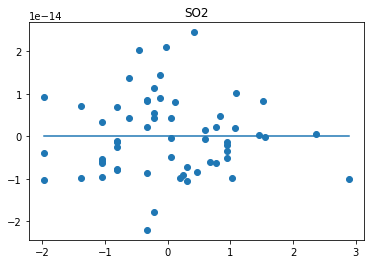

In [10]:
# The transformed variables give a much better fit, with a greatly improved loss value.
# We can also plot the residuals again, and we see that they are also improved.
for i, f in enumerate([ f for f in m_fields if f != 'Mortality']):
  plt.plot(sorted(m_X_transformed_scaled.T[i]), np.zeros_like(m_Y_scaled))
  plt.scatter(m_X_transformed_scaled.T[i], m_Y_scaled - m_X_ts_inter.dot(m_beta_gd))
  plt.title(f)
  plt.show()